## Installing Lucent 

In [ ]:
!pip install --quiet git+https://github.com/atagade/lucent

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.8/227.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 KB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 KB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.8/316.8 KB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 KB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 KB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

## Importing libraries

In [ ]:
from itertools import product
import sys
from PIL import Image

import numpy as np
import torch
import torchvision

from lucent.modelzoo import *
from lucent.misc.io import show
import lucent.optvis.objectives as objectives
import lucent.optvis.param as param
import lucent.optvis.render as render
import lucent.optvis.transform as transform
from lucent.misc.channel_reducer import ChannelReducer
from lucent.misc.io import show

## Torchvision ResNet module

In [ ]:
from lucent.modelzoo import custom_resnet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = custom_resnet.resnet18(pretrained=True, skip_batchnorm=False).to(device).eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
from lucent.modelzoo.util import get_model_layers

get_model_layers(model)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer1_0',
 'layer1_0_conv1',
 'layer1_0_bn1',
 'layer1_0_relu',
 'layer1_0_conv2',
 'layer1_0_bn2',
 'layer1_1',
 'layer1_1_conv1',
 'layer1_1_bn1',
 'layer1_1_relu',
 'layer1_1_conv2',
 'layer1_1_bn2',
 'layer2',
 'layer2_0',
 'layer2_0_conv1',
 'layer2_0_bn1',
 'layer2_0_relu',
 'layer2_0_conv2',
 'layer2_0_bn2',
 'layer2_0_downsample',
 'layer2_0_downsample_0',
 'layer2_0_downsample_1',
 'layer2_1',
 'layer2_1_conv1',
 'layer2_1_bn1',
 'layer2_1_relu',
 'layer2_1_conv2',
 'layer2_1_bn2',
 'layer3',
 'layer3_0',
 'layer3_0_conv1',
 'layer3_0_bn1',
 'layer3_0_relu',
 'layer3_0_conv2',
 'layer3_0_bn2',
 'layer3_0_downsample',
 'layer3_0_downsample_0',
 'layer3_0_downsample_1',
 'layer3_1',
 'layer3_1_conv1',
 'layer3_1_bn1',
 'layer3_1_relu',
 'layer3_1_conv2',
 'layer3_1_bn2',
 'layer4',
 'layer4_0',
 'layer4_0_conv1',
 'layer4_0_bn1',
 'layer4_0_relu',
 'layer4_0_conv2',
 'layer4_0_bn2',
 'layer4_0_downsample',
 'layer4_0_downsampl

## Helper functions

In [ ]:
@torch.no_grad()
def get_layer(model, layer, X):
    hook = render.ModuleHook(getattr(model, layer))
    model(X)
    hook.close()
    return hook.features


@objectives.wrap_objective()
def dot_compare(layer, acts, batch=1):
    def inner(T):
        pred = T(layer)[batch]
        return -(pred * acts).sum(dim=0, keepdims=True).mean()

    return inner


## Naive implementation

In [ ]:
def render_activation_grid_very_naive(
    img, model, layer="layer3", cell_image_size=48, n_steps=1024
):
    # First wee need, to normalize and resize the image
    img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
    normalize = (
        transform.preprocess_inceptionv1()
        if model._get_name() == "InceptionV1"
        else transform.normalize()
    )
    transforms = [
        normalize,
        torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
    ]
    transforms_f = transform.compose(transforms)
    # shape: (1, 3, original height of img, original width of img)
    img = img.unsqueeze(0)
    # shape: (1, 3, 224, 224)
    img = transforms_f(img)

    # Here we compute the activations of the layer `layer` using `img` as input
    # shape: (layer_channels, layer_height, layer_width), the shape depends on the layer
    acts = get_layer(model, layer, img)[0]
    layer_channels, layer_height, layer_width = acts.shape
    # for each position `(y, x)` in the feature map `acts`, we optimize an image
    # to match with the features `acts[:, y, x]`
    # This means that the total number of cells (which is the batch size here) 
    # in the grid is layer_height*layer_width.
    nb_cells = layer_height * layer_width

    # Parametrization of the of each cell in the grid
    param_f = lambda: param.image(
        cell_image_size, batch=nb_cells
    )
    params, image_f = param_f()

    obj = objectives.Objective.sum(
        [
            # for each position in `acts`, maximize the dot product between the activations
            # `acts` at the position (y, x) and the features of the corresponding
            # cell image on our 'grid'. The activations at (y, x) is a vector of size
            # `layer_channels` (this depends on the `layer`). The features
            # of the corresponding cell on our grid is a tensor of shape
            # (layer_channels, cell_layer_height, cell_layer_width).
            # Note that cell_layer_width != layer_width and cell_layer_height != layer_weight
            # because the cell image size is smaller than the image size.
            # With `dot_compare`, we maximize the dot product between
            # cell_activations[y_cell, x_xcell] and acts[y,x] (both of size `layer_channels`)
            # for each possible y_cell and x_cell, then take the average to get a single
            # number. Check `dot_compare for more details.`
            dot_compare(layer, acts[:, y:y+1, x:x+1], batch=x + y * layer_width)
            for i, (x, y) in enumerate(product(range(layer_width), range(layer_height)))
        ]
    )
    results = render.render_vis(
        model,
        obj,
        param_f,
        thresholds=(n_steps,),
        progress=True,
        fixed_image_size=cell_image_size,
        show_image=False,
    )
    # shape: (layer_height*layer_width, cell_image_size, cell_image_size, 3)
    imgs = results[-1] # last step results
    # shape: (layer_height*layer_width, 3, cell_image_size, cell_image_size)
    imgs = imgs.transpose((0, 3, 1, 2))
    imgs = torch.from_numpy(imgs)
    imgs = imgs[:, :, 2:-2, 2:-2]
    # turn imgs into a a grid
    grid = torchvision.utils.make_grid(imgs, nrow=int(np.sqrt(nb_cells)), padding=0)
    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    render.show(grid)
    return imgs

100%|██████████| 1024/1024 [01:56<00:00,  8.78it/s]



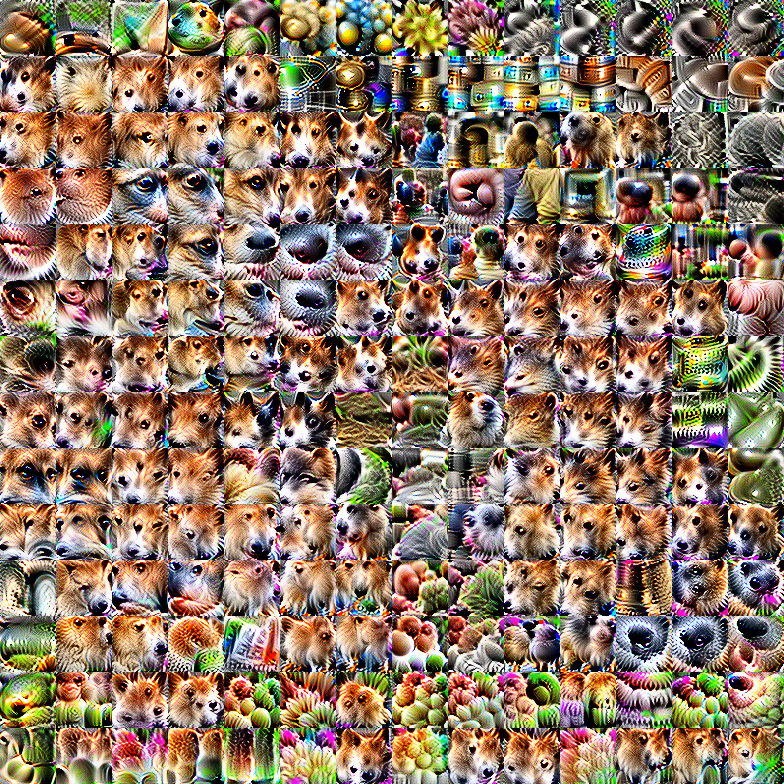

In [ ]:
img = np.array(Image.open("dog_cat.jpeg"), np.float32)
img = img / 255
_ = render_activation_grid_very_naive(img, model, layer="layer3", cell_image_size=60, n_steps=1024)

## Less naive implementation

In [ ]:
def render_activation_grid_less_naive(
    img,
    model,
    layer="mixed4d",
    cell_image_size=60,
    n_groups=6,
    n_steps=1024,
    batch_size=64,
):
    # First wee need, to normalize and resize the image
    img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
    normalize = (
        transform.preprocess_inceptionv1()
        if model._get_name() == "InceptionV1"
        else transform.normalize()
    )
    transforms = transform.standard_transforms.copy() + [
        torch.nn.Upsample(size=224, mode="bilinear", align_corners=True),
    ]
    transforms_f = transform.compose(transforms)
    # shape: (1, 3, original height of img, original width of img)
    img = img.unsqueeze(0)
    # shape: (1, 3, 224, 224)
    img = transforms_f(img)

    # Here we compute the activations of the layer `layer` using `img` as input
    # shape: (layer_channels, layer_height, layer_width), the shape depends on the layer
    acts = get_layer(model, layer, img)[0]
    # shape: (layer_height, layer_width, layer_channels)
    acts = acts.permute(1, 2, 0)
    # shape: (layer_height*layer_width, layer_channels)
    acts = acts.view(-1, acts.shape[-1])
    acts_np = acts.cpu().numpy()
    nb_cells = acts.shape[0]

    # negative matrix factorization `NMF` is used to reduce the number
    # of channels to n_groups. This will be used as the following.
    # Each cell image in the grid is decomposed into a sum of
    # (n_groups+1) images. First, each cell has its own set of parameters
    #  this is what is called `cells_params` (see below). At the same time, we have
    # a of group of images of size 'n_groups', which also have their own image parametrized
    # by `groups_params`. The resulting image for a given cell in the grid
    # is the sum of its own image (parametrized by `cells_params`)
    # plus a weighted sum of the images of the group. Each each image from the group
    # is weighted by `groups[cell_index, group_idx]`. Basically, this is a way of having
    # the possibility to make cells with similar activations have a similar image, because
    # cells with similar activations will have a similar weighting for the elements
    # of the group.
    if n_groups > 0:
        reducer = ChannelReducer(n_groups, "NMF")
        groups = reducer.fit_transform(acts_np)
        groups /= groups.max(0)
    else:
        groups = np.zeros([])
    # shape: (layer_height*layer_width, n_groups)
    groups = torch.from_numpy(groups)

    # Parametrization of the images of the groups (we have 'n_groups' groups)
    groups_params, groups_image_f = param.fft_image(
        [n_groups, 3, cell_image_size, cell_image_size]
    )
    # Parametrization of the images of each cell in the grid (we have 'layer_height*layer_width' cells)
    cells_params, cells_image_f = param.fft_image(
        [nb_cells, 3, cell_image_size, cell_image_size]
    )

    # First, we need to construct the images of the grid
    # from the parameterizations

    def image_f():
        groups_images = groups_image_f()
        cells_images = cells_image_f()
        X = []
        for i in range(nb_cells):
            x = 0.7 * cells_images[i] + 0.5 * sum(
                groups[i, j] * groups_images[j] for j in range(n_groups)
            )
            X.append(x)
        X = torch.stack(X)
        return X

    # make sure the images are between 0 and 1
    image_f = param.to_valid_rgb(image_f, decorrelate=True)

    # After constructing the cells images, we sample randomly a mini-batch of cells
    # from the grid. This is to prevent memory overflow, especially if the grid
    # is large.
    def sample(image_f, batch_size):
        def f():
            X = image_f()
            inds = torch.randint(0, len(X), size=(batch_size,))
            inputs = X[inds]
            # HACK to store indices of the mini-batch, because we need them
            # in objective func. Might be better ways to do that
            sample.inds = inds
            return inputs

        return f

    image_f_sampled = sample(image_f, batch_size=batch_size)

    # Now, we define the objective function

    def objective_func(model):
        # shape: (batch_size, layer_channels, cell_layer_height, cell_layer_width)
        pred = model(layer)
        # use the sampled indices from `sample` to get the corresponding targets
        target = acts[sample.inds].to(pred.device)
        # shape: (batch_size, layer_channels, 1, 1)
        target = target.view(target.shape[0], target.shape[1], 1, 1)
        dot = (pred * target).sum(dim=1).mean()
        return -dot

    obj = objectives.Objective(objective_func)

    def param_f():
        # We optimize the parametrizations of both the groups and the cells
        params = list(groups_params) + list(cells_params)
        return params, image_f_sampled

    results = render.render_vis(
        model,
        obj,
        param_f,
        thresholds=(n_steps,),
        show_image=False,
        progress=True,
        fixed_image_size=cell_image_size,
    )
    # shape: (layer_height*layer_width, 3, grid_image_size, grid_image_size)
    imgs = image_f()
    imgs = imgs.cpu().data
    imgs = imgs[:, :, 2:-2, 2:-2]
    # turn imgs into a a grid
    grid = torchvision.utils.make_grid(imgs, nrow=int(np.sqrt(nb_cells)), padding=0)
    grid = grid.permute(1, 2, 0)
    grid = grid.numpy()
    render.show(grid)
    return imgs

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
100%|██████████| 1024/1024 [02:38<00:00,  6.45it/s]



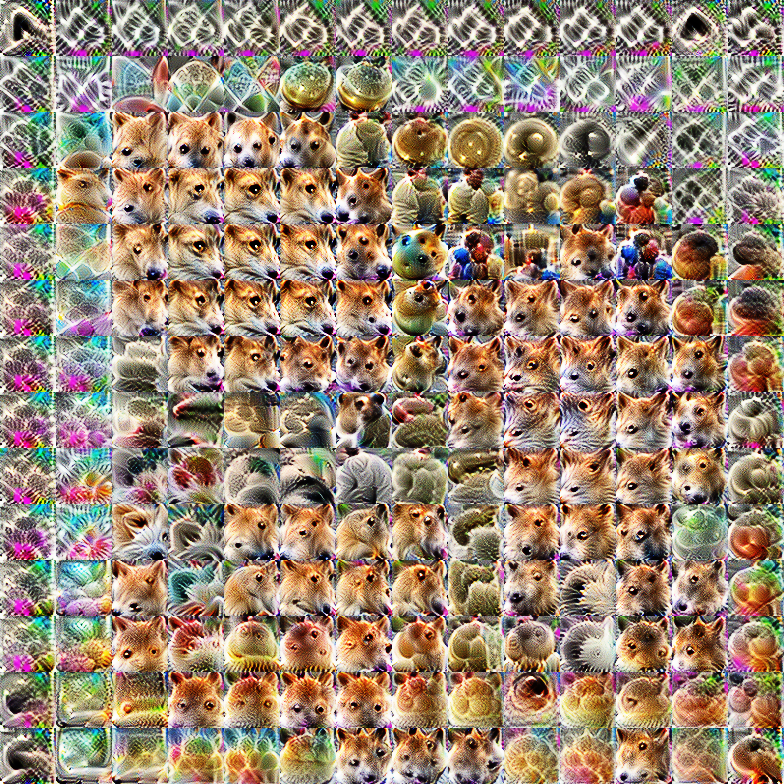

In [ ]:
img = np.array(Image.open("dog_cat.jpeg"), np.float32)
img = img / 255
_ = render_activation_grid_less_naive(
    img, model, cell_image_size=60, layer="layer3", n_steps=1024, batch_size=64
)

In [ ]:
img.shape

(224, 224, 3)